In [1]:
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit import *
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

In [36]:
gz = 0
anti = 1

L = 5
num_trash = 2
logspace_size = 6
name = f"qsim_params_VQE_Ising_L{L:.0f}_anti_{anti:.0f}_{logspace_size}"
filename = 'data/' + name
print(filename)
gx_vals = np.logspace(-2,2,logspace_size)

data/qsim_params_VQE_Ising_L5_anti_1_6


In [23]:
IBMQ.load_account() # this then automatically loads your saved account
provider = IBMQ.get_provider(hub='ibm-q-research')

real_backend = provider.backends(simulator=False, operational=True)[6]
backend = qiskit.providers.aer.AerSimulator.from_backend(real_backend)

In [28]:
# more in-depth noise models https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html
#backend = qiskit.Aer.get_backend('qasm_simulator') # apparently outdated (legacy)
backend = qiskit.providers.aer.AerSimulator.from_backend(real_backend)
backend_sim = backend

In [29]:
ansatz = qiskit.circuit.library.EfficientSU2(L, reps=3)

#optimizer = SLSQP(maxiter=1000)
optimizer = COBYLA(maxiter=1000)
#optimizer = SPSA(maxiter=1000)

vqe = VQE(ansatz, optimizer, quantum_instance=backend) 

In [30]:
gx = 1e-1
t0 = datetime.datetime.now()
H = QHIsing(L,anti,np.float32(gx),np.float32(gz))
result = vqe.compute_minimum_eigenvalue(H, aux_operators=[QMag(L,anti)]) #ED with Qiskit VQE
print(f"elapsed time {datetime.datetime.now()-t0}")

Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


elapsed time 0:00:41.567444


### Checks to get magnetization most efficiently

In [31]:
def simple_mag(L,i):
    return (I^i)^Z^(I^(L-i-1))

In [32]:
[simple_mag(L,i) for i in range(L)]

[PauliOp(Pauli('ZIIII'), coeff=1.0),
 PauliOp(Pauli('IZIII'), coeff=1.0),
 PauliOp(Pauli('IIZII'), coeff=1.0),
 PauliOp(Pauli('IIIZI'), coeff=1.0),
 PauliOp(Pauli('IIIIZ'), coeff=1.0)]

In [33]:
gx = 1e-1
t0 = datetime.datetime.now()
H = QHIsing(L,anti,np.float32(gx),np.float32(gz))
result = vqe.compute_minimum_eigenvalue(H, aux_operators=[simple_mag(L,i) for i in range(L)]) #ED with Qiskit VQE
print(f"mag: {np.sum(result.aux_operator_eigenvalues)}")
print(f"elapsed time {datetime.datetime.now()-t0}")

mag: 0.552734375
elapsed time 0:00:44.229702


In [34]:
gx = 1e-1
t0 = datetime.datetime.now()
H = QHIsing(L,anti,np.float32(gx),np.float32(gz))
result = vqe.compute_minimum_eigenvalue(H) #ED with Qiskit VQE
print(f"elapsed time {datetime.datetime.now()-t0}")

elapsed time 0:00:40.303106


In [35]:
gx = 1e-1
t0 = datetime.datetime.now()
H = QHIsing(L,anti,np.float32(gx),np.float32(gz))
result = vqe.compute_minimum_eigenvalue(H, aux_operators=[QMag(L,anti)]) #ED with Qiskit VQE
print(f"mag: {result.aux_operator_eigenvalues}")
print(f"elapsed time {datetime.datetime.now()-t0}")

Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


mag: [[0.04570312500000001]]
elapsed time 0:00:41.699083


# VQE calculation

In [37]:
opt_params = []
gx_list = []
Qmags = []
mag = QMag(L,anti) #magnetization operator (Qiskit)
Qen = []

for i,gx in enumerate(gx_vals):
    t0 = datetime.datetime.now()
    print('{} / {}, gx: {:.2f}, gz: {:.2f}'.format(i+1, len(gx_vals),gx,gz))

    H = QHIsing(L,anti,np.float32(gx),np.float32(gz))
    result = vqe.compute_minimum_eigenvalue(H, aux_operators=[mag])
    print(result.aux_operator_eigenvalues[0][0])
    Qmags.append(result.aux_operator_eigenvalues[0][0])
    Qen.append(result.eigenvalue)
    gx_list.append(gx)
    opt_params.append(sort_params(result.optimal_parameters))
    print(f"elapsed time {datetime.datetime.now()-t0}")

np.savez(filename, gx_list=gx_list, gz_list=[0]*len(gx_list), opt_params=opt_params, Qmags = Qmags, Qen = Qen)


1 / 6, gx: 0.01, gz: 0.00


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


-0.062890625
elapsed time 0:00:41.410656
2 / 6, gx: 0.06, gz: 0.00


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


0.037499999999999985
elapsed time 0:00:51.691065
3 / 6, gx: 0.40, gz: 0.00


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


0.05937500000000001
elapsed time 0:00:46.137304
4 / 6, gx: 2.51, gz: 0.00


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


-0.017578124999999997
elapsed time 0:00:37.192313
5 / 6, gx: 15.85, gz: 0.00


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


0.096875
elapsed time 0:00:41.381915
6 / 6, gx: 100.00, gz: 0.00


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


0.00585937500000001
elapsed time 0:00:42.108019


### Exact Diagonalization

In [38]:
VQE_params = np.load(filename + ".npz", allow_pickle=True)
gx_list = VQE_params['gx_list']
gz_list = VQE_params['gz_list']
opt_params = VQE_params['opt_params']

gx_vals = np.unique(gx_list) # Rike and Joana convention
gz_vals = np.unique(gz_list)

phis = opt_params
gxs = gx_list
gzs = gz_list

mag = QMag(L,anti) #magnetization operator (Qiskit)
Smag = Mag(L,anti) #magnetization operator (numpy)

Sen=np.zeros(len(opt_params), dtype=np.complex128) #energies
Smags=np.zeros(len(opt_params), dtype=np.complex128) #magnetizations

In [39]:
for j in range(len(opt_params)):

    gx = gx_list[j]
    gz = gz_list[j]

    init_state, E, ham = ising_groundstate(L, anti, np.float32(gx), np.float32(gz))
    Sen[j] = E
    Smags[j] = init_state.T.conj()@Smag@init_state #Magnetization with Numpy results
#np.savez(filename + "_ED_results",Qmags=Qmags, Qen=Qen, Sen=Sen, Smags=Smags) # for large parameter space takes quite a while because of the exact diagonalization

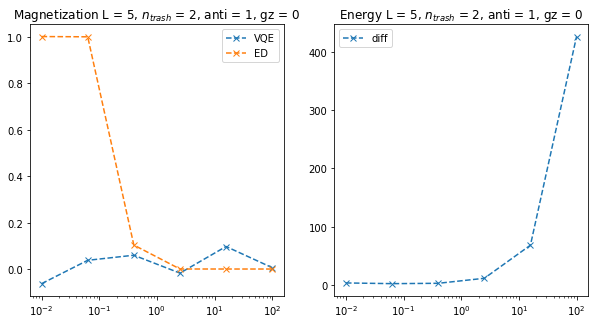

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(gxs, Qmags,"x--", label="VQE")
ax.plot(gxs, Smags.real,"x--", label="ED")
ax.set_title(f"Magnetization L = {L}, $n_{{trash}}$ = {num_trash}, anti = {anti}, gz = {gz}")
ax.set_xscale("log")
ax.legend()

ax = axs[1]
ax.plot(gxs, Qen-Sen.real,"x--", label="diff")
ax.set_title(f"Energy L = {L}, $n_{{trash}}$ = {num_trash}, anti = {anti}, gz = {gz}")
ax.set_xscale("log")
ax.legend()
plt.savefig("plots/" + name + "magnetization.png")

In [38]:
##############################################################################
### II - Training  ###########################################################
##############################################################################

thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [45]:
# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1):
    result = []
    nums = list(range(L)) # here was the problem, it doesnt like when list elements are taken from numpy
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

def QAE_Ansatz(thetas, L, num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    circ = qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                           skip_final_rotation_layer=True
                                          ).assign_parameters(thetas[:-num_trash])
    if insert_barriers: circ.barrier()
    for i in range(num_trash):
        circ.ry(thetas[L-i-1], L-i-1)
        #circ.ry(circuit.Parameter(f'θ{i}'), L-i-1)
    return circ

def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True, vqe=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(num_trash, 'c')
    circ = QuantumCircuit(qreg, creg)
    circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
    if measurement:
        for i in range(num_trash):
            circ.measure(qreg[L-i-1], creg[i])
    if init_state is not None:
        if vqe:
            circ = init_vqe(init_state,L=L) + circ
        else:
            circ.initialize(init_state, qreg)
    return circ

In [46]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [47]:
def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=100):
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots, seed_simulator=123, seed_transpiler=234) # fix seed to make it reproducible

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
phi = opt_params[0]
run_circuit(thetas, L, num_trash, phi)['11']

<ipython-input-45-a05c1f5c1b9e>:37: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
<ipython-input-45-a05c1f5c1b9e>:43: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = init_vqe(init_state,L=L) + circ
/home/kkottmann/anaconda3/envs/

23

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [49]:


def cost_function_single(thetas, L, num_trash, p, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    if vqe:
        init_state = phis[p]
    else:
        J, gx, gz = p
        init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

def cost_function(thetas, L, num_trash, ising_params, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        if param_encoding: 
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, x[i])
        else:
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding)
    return cost/n_samples

def optimize(ising_params, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None):
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         #learning_rate=1e-1,
                         #perturbation=0.4
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted



In [50]:
def run_inference(thetas, shots=1000, L=5):
    cost = np.zeros((len(gx_vals)))
    shots = 1000
    for i,p in enumerate(list(zip(gxs, gzs))):
            cost[i] = cost_function_single(thetas, L, num_trash, i, shots=shots)
    return cost

## Training on bottom-left

In [52]:
paramss =[
    [0], # train on bottom left point
]

In [54]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")

1 / 1 - params (gz, gx) in [(0, 0.01)]


In [55]:
thetass = [None] * len(paramss)
losss = [None] * len(paramss)
costs = [None] * len(paramss)

## Run 1

1 / 1 - params (gz, gx) in [(0, 0.01)]
Initial cost: 1.069
Time: 26.65872 sec
(array([ 5.32756975, -1.45493624,  3.7899829 ,  6.76658342,  5.1009913 ,
        1.08606106, -0.97363079,  2.74248751,  4.27880354, -2.74954995,
        4.31288663, -1.43048015]), 0.793, 300)


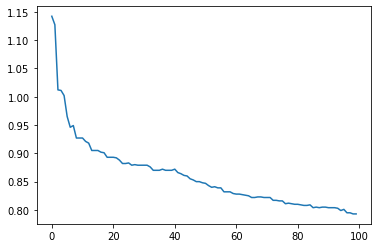

In [56]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    thetas, loss, accepted = optimize(params, max_iter=100, L=5) #, pick_optimizer="adam")
    thetass[i], losss[i] = thetas, loss
    plt.plot(loss)
    cost = run_inference(thetas)
    costs[i] = cost

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, '$g_x$')

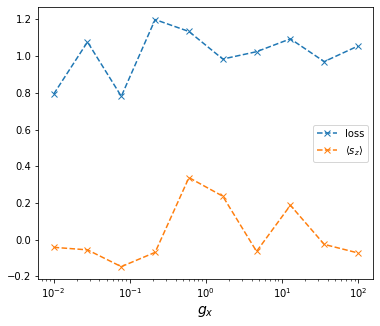

In [65]:
fig, ax = plt.subplots(ncols=1, figsize=(6,5))
ax.plot(gxs,cost,"x--", label = "loss")
ax.plot(gxs,Qmags,"x--", label="$\\langle s_z \\rangle$")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("$g_x$", fontsize= 14)